In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import pearsonr
import nibabel as nb
import seaborn as sns
import plot_funcs
from numpy import genfromtxt
import pygeodesic
import pygeodesic.geodesic as geodesic
from brainspace.datasets import load_conte69, load_mask
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import reduce_by_labels
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient import GradientMaps


## heritability of t1w/t2w intensity maps

In [2]:
# function for fdr corrections
def FDR_sofie(p, q):
    # p : 1D np array, vector of p-values
    # q : float, false discovery rate level
    p = np.sort(p)
    V = len(p)
    I = np.arange(1,V+1)
    cVID = 1
    cVN  = (1 / np.arange(1,V+1)).sum()
    pID  = p[np.max(np.where(p <= (I / V*q / cVID)))]
    pN   = np.where(p <= (I / V*q / cVN))
    return pID, pN



### SUB (left)

In [3]:
# we will read heritability values from 1024 sub vertices
tot_node_num_lsub = 1024
node_str = []
for i in range(1, tot_node_num_lsub+1):
    node_str.append(i)
# empty data frame to be filled out
df_herit_t1t2_LSUB = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])


In [4]:
# read-in heritability scores 
fLSUB = '../solar/solar_msm50_t1t2_lsub/t1t2_LSUB_results_herit.txt'
herit_t1t2_LSUB = pd.read_csv(fLSUB, index_col = 0, header = 0)
herit_t1t2_LSUB.index.name = 'node'

for nodeID in range(1, tot_node_num_lsub+1):

    iA = herit_t1t2_LSUB.index.get_loc(nodeID)
    iB = df_herit_t1t2_LSUB.index.get_loc(nodeID)

    df_herit_t1t2_LSUB.iloc[iB]['H2r'] = herit_t1t2_LSUB.iloc[iA]['H2r']
    df_herit_t1t2_LSUB.iloc[iB]['rp']  = herit_t1t2_LSUB.iloc[iA]['rp']

dataLSUB = np.array(df_herit_t1t2_LSUB['H2r'], dtype = 'float')
pLSUB = np.array(df_herit_t1t2_LSUB['rp'], dtype = 'float')

q = 0.05
pID, pN = FDR_sofie(pLSUB, q)
pID, len(np.where(dataLSUB <= pID)[0]), dataLSUB.max()


(0.0347893, 0, 0.7679011)

In [5]:
dataLSUB.mean(), dataLSUB.std()

(0.440472726953125, 0.14687146806816007)

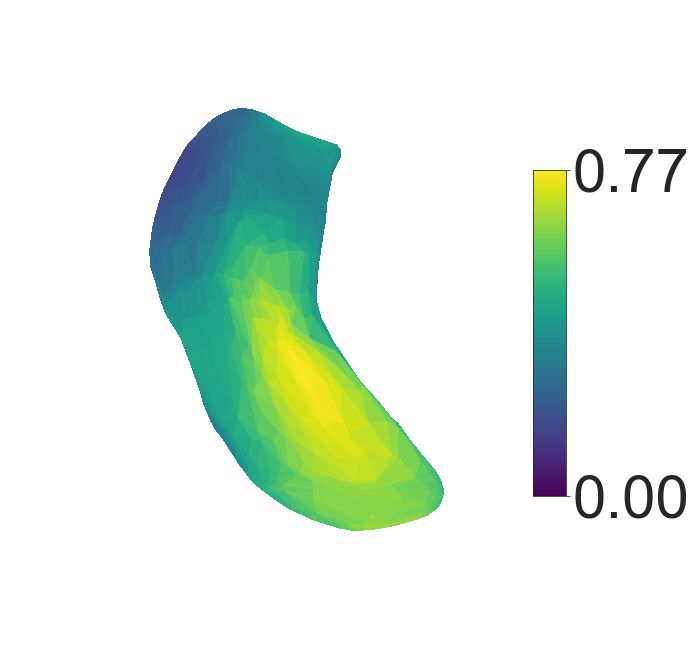

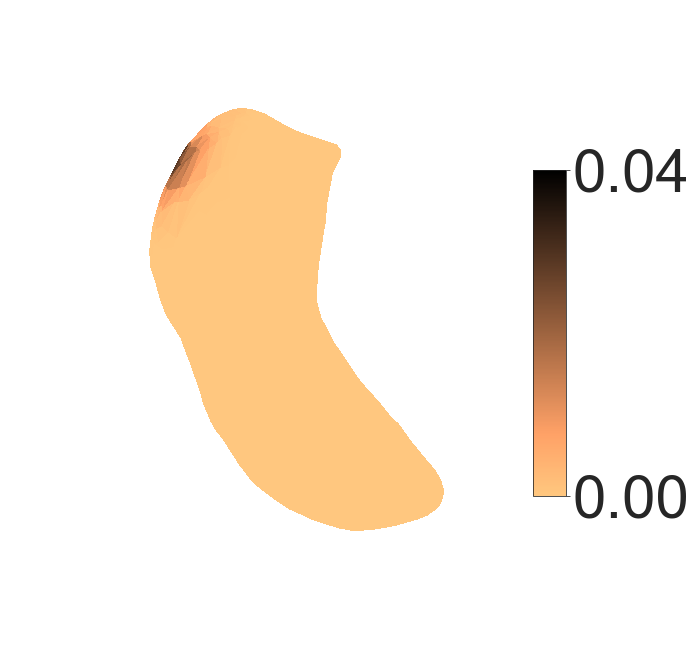

In [6]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  dataLSUB,
                                  'viridis',
                                  0, 0.77)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  pLSUB,
                                  'copper_r',
                                  0, 0.04)

#fig1.savefig('../figures/herit_t1wt2w_lsub_H.svg', dpi=300)
#fig2.savefig('../figures/herit_t1wt2w_lsub_P.svg', dpi=300)


### CA (left)

In [7]:
tot_node_num_lca = 2048
node_str = []
for i in range(1, tot_node_num_lca+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]
# empty data frame to be filled out
df_herit_t1t2_LCA = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])


2048


In [8]:
# read-in heritability scores 
fLCA = '../solar/solar_msm50_t1t2_lca/t1t2_LCA_results_herit.txt'
herit_t1t2_LCA = pd.read_csv(fLCA, index_col = 0, header = 0)
herit_t1t2_LCA.index.name = 'node'

for nodeID in range(1, tot_node_num_lca+1):

    iA = herit_t1t2_LCA.index.get_loc(nodeID)
    iB = df_herit_t1t2_LCA.index.get_loc(nodeID)

    df_herit_t1t2_LCA.iloc[iB]['H2r'] = herit_t1t2_LCA.iloc[iA]['H2r']
    df_herit_t1t2_LCA.iloc[iB]['rp']  = herit_t1t2_LCA.iloc[iA]['rp']

dataLCA = np.array(df_herit_t1t2_LCA['H2r'], dtype = 'float')
pLCA = np.array(df_herit_t1t2_LCA['rp'], dtype = 'float')

q = 0.05
pID, pN = FDR_sofie(pLCA, q)
pID, len(np.where(pLCA <= pID)[0]), dataLCA.max()


(0.047305400000000004, 2035, 0.6141778)

In [9]:
dataLCA.mean(), dataLCA.std()

(0.4064786228027344, 0.12079749347044803)

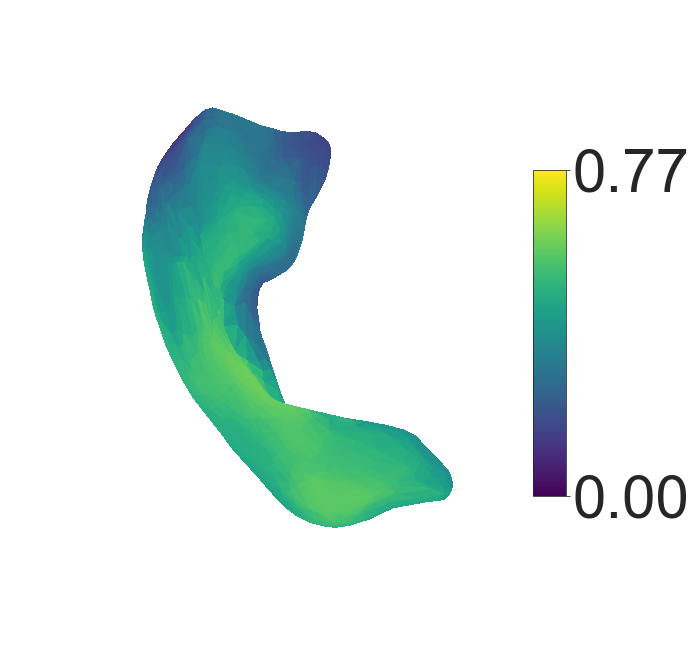

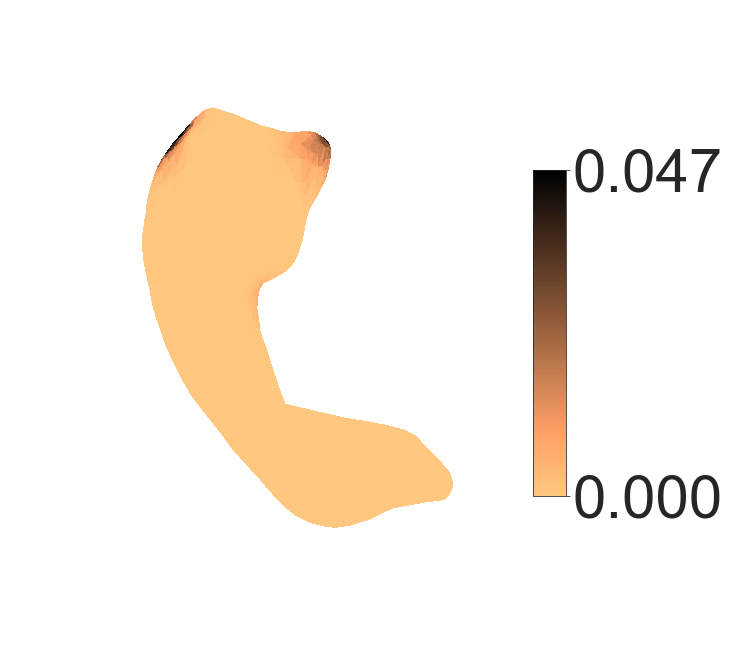

In [10]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                  plot_funcs.yLCA, 
                                  plot_funcs.zLCA, 
                                  plot_funcs.triLCA, 
                                  dataLCA,
                                  'viridis',
                                  0, 0.77)

fig2 = plot_funcs.plot_surf_upper3(plot_funcs.xLCA, 
                                  plot_funcs.yLCA, 
                                  plot_funcs.zLCA, 
                                  plot_funcs.triLCA, 
                                  pLCA,
                                  'copper_r',
                                  0, pID)

#fig1.savefig('../figures/herit_t1wt2w_lca_H.svg', dpi=300)
#fig2.savefig('../figures/herit_t1wt2w_lca_P.svg', dpi=300)


### DG (left)

In [11]:
tot_node_num_ldg = 1024
node_str = []
for i in range(1, tot_node_num_ldg+1):
    node_str.append(i)
print(len(node_str))
node_str[0], '...', node_str[-1]
# empty data frame to be filled out
df_herit_t1t2_LDG = pd.DataFrame(index = node_str, columns = ['H2r', 'rp'])


1024


In [12]:
# read-in heritability scores 
fLDG = '../solar/solar_msm50_t1t2_ldg/t1t2_LDG_results_herit.txt'
herit_t1t2_LDG = pd.read_csv(fLDG, index_col = 0, header = 0)
herit_t1t2_LDG.index.name = 'node'

for nodeID in range(1, tot_node_num_ldg+1):

    iA = herit_t1t2_LDG.index.get_loc(nodeID)
    iB = df_herit_t1t2_LDG.index.get_loc(nodeID)

    df_herit_t1t2_LDG.iloc[iB]['H2r'] = herit_t1t2_LDG.iloc[iA]['H2r']
    df_herit_t1t2_LDG.iloc[iB]['rp']  = herit_t1t2_LDG.iloc[iA]['rp']

dataLDG = np.array(df_herit_t1t2_LDG['H2r'], dtype = 'float')
pLDG = np.array(df_herit_t1t2_LDG['rp'], dtype = 'float')

q = 0.05
pID, pN = FDR_sofie(pLDG, q)
pID, len(np.where(pLDG <= pID)[0]), dataLDG.max()


(0.0017930999999999997, 1024, 0.5723038)

In [13]:
dataLDG.mean(), dataLDG.std()

(0.43368091132812503, 0.07071698283294162)

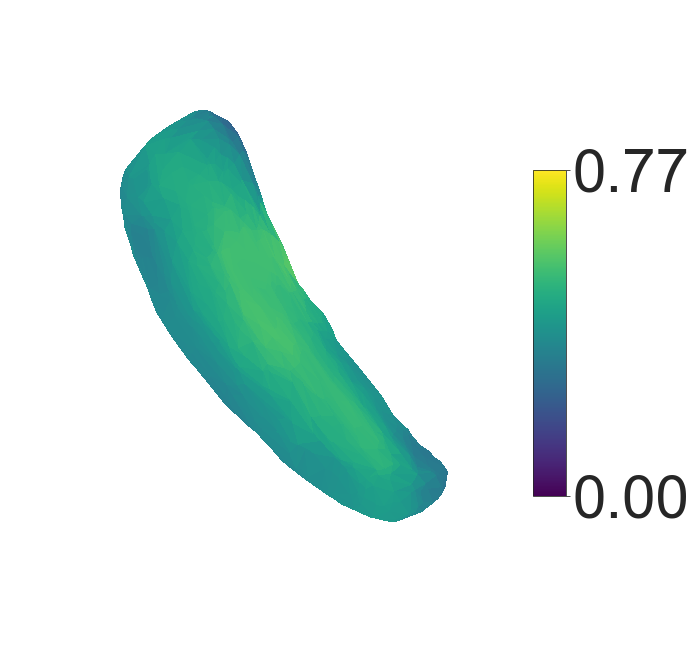

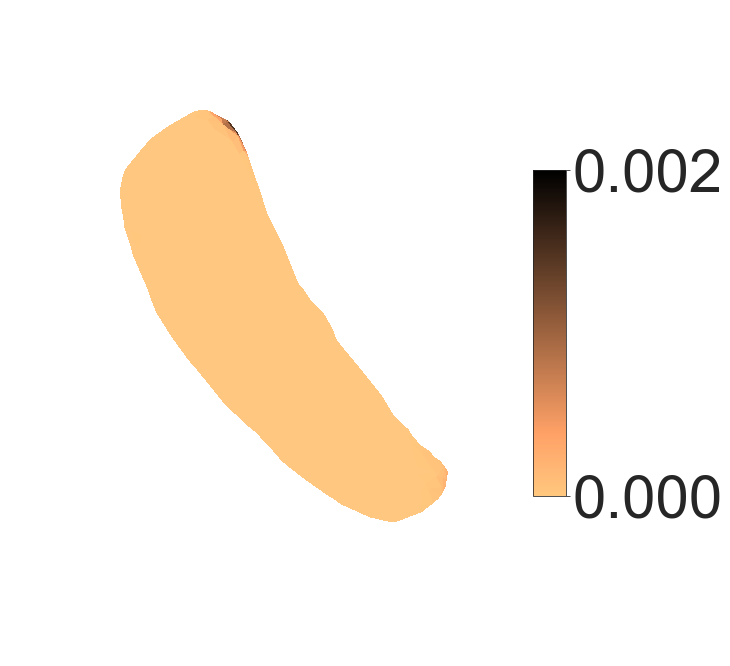

In [14]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                  plot_funcs.yLDG, 
                                  plot_funcs.zLDG, 
                                  plot_funcs.triLDG, 
                                  dataLDG,
                                  'viridis',
                                  0, 0.77)

fig2 = plot_funcs.plot_surf_upper3(plot_funcs.xLDG, 
                                  plot_funcs.yLDG, 
                                  plot_funcs.zLDG, 
                                  plot_funcs.triLDG, 
                                  pLDG,
                                  'copper_r',
                                  0, pID)

#fig1.savefig('../figures/herit_t1wt2w_ldg_H.svg', dpi=300)
#fig2.savefig('../figures/herit_t1wt2w_ldg_P.svg', dpi=300)


## read-in cortical myelin (in vivo, T1w/T2w) measures across all subjects

In [15]:
ddir = '../data/tout_group'

h1 = h5py.File(os.path.join(ddir, 'H709_mye_cortex.h5'), 'r')

mye_cortex = np.array(h1['data']).T; h1.close()

mye_cortex.shape, mye_cortex.min(), mye_cortex.max()



((709, 360), 0.02919340319931507, 4.150848388671875)

In [16]:
# Glasser Labels
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)
print(labeling.shape, labeling.min(), labeling.max())

# load surfaces
surf_lh, surf_rh = load_conte69()
mask = labeling != 0 # this takes the mask of the left hem only..
mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


(64984,) 0.0 360.0


In [17]:
# get the mean myelin measure across subjects & label to freesurfer
mye_cortex_mean = mye_cortex.mean(axis=0)
print(mye_cortex_mean.shape)

mye_cortex_mean_labeled = map_to_labels(mye_cortex_mean, labeling, mask=mymask) 
mye_cortex_mean_labeled[np.where(mymask == False)] = np.nan
print(mye_cortex_mean_labeled.shape)



(360,)
(64984,)


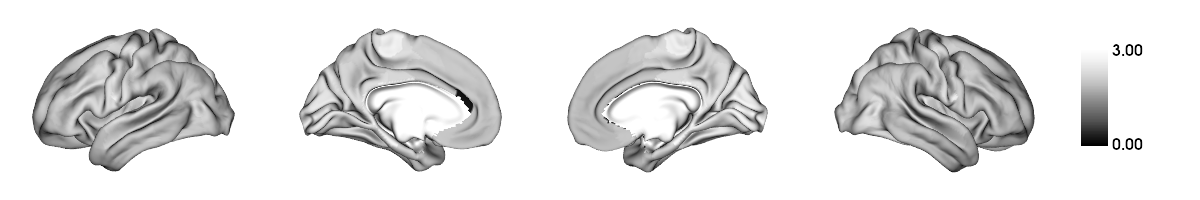

In [18]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = mye_cortex_mean_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'Greys_r', 
                 color_bar = True,
                 color_range = (0., 3),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_cortex_mye.svg'
                 )

## read-in the gradients data of the structural intensity of covariance (sic)


In [19]:
outdir = '../data/tout_group/'

h = h5py.File(os.path.join(outdir, 'Hmean709scovGradients_left.h5'), 'r')
data = np.array(h['data']).T

G1_sic_LSUB = data[0:1024,0]
G1_sic_LCA  = data[1024:1024+2048,0]
G1_sic_LDG  = data[1024+2048:1024+2048+1024,0] 

G2_sic_LSUB = data[0:1024,1]
G2_sic_LCA  = data[1024:1024+2048,1]
G2_sic_LDG  = data[1024+2048:1024+2048+1024,1] 


### G1 (sic)

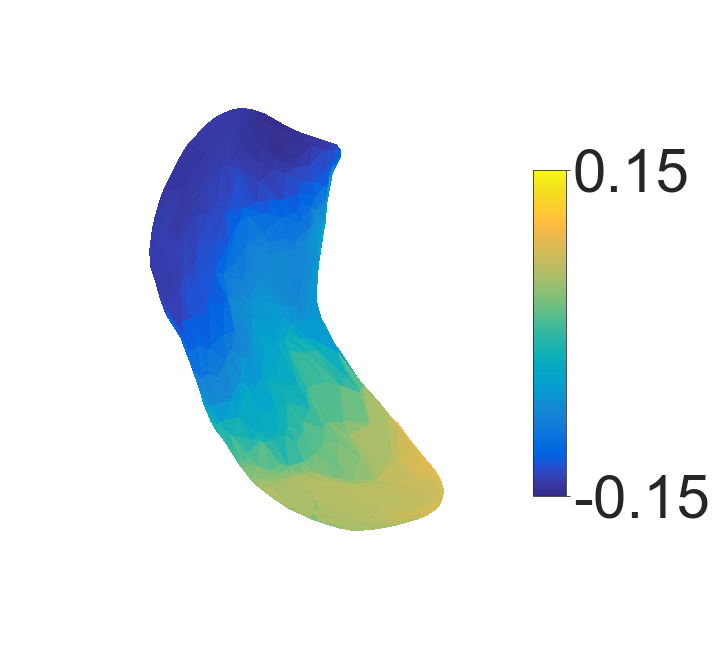

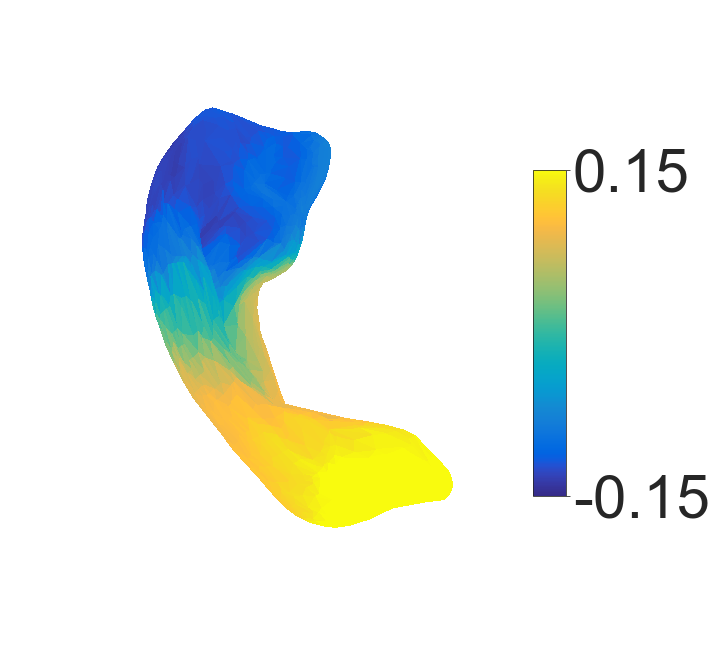

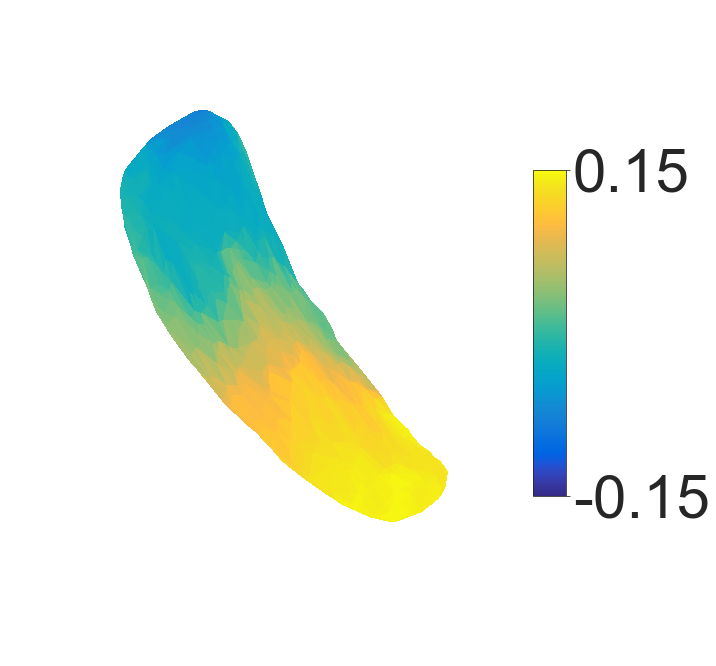

In [20]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G1_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)


fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.15, 0.15)


### G2 (sic)

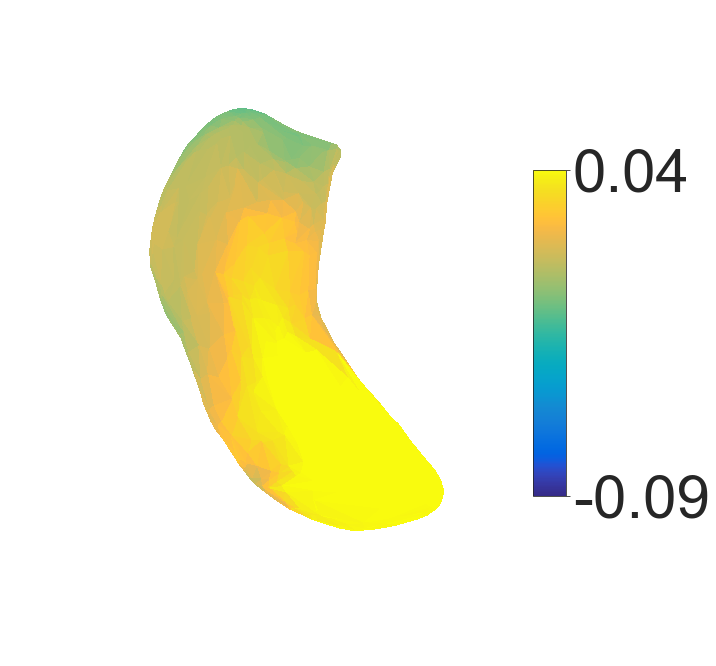

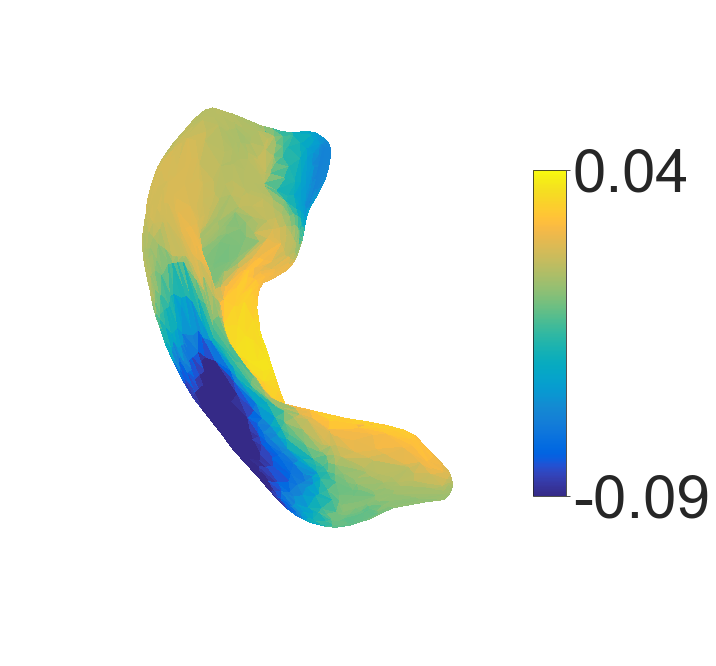

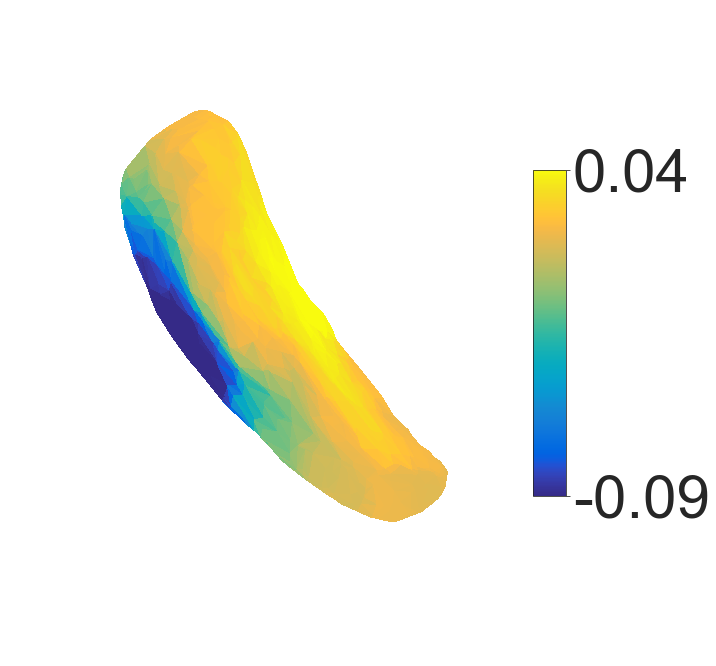

In [21]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB, 
                                   plot_funcs.yLSUB, 
                                   plot_funcs.zLSUB, 
                                   plot_funcs.triLSUB, 
                                   G2_sic_LSUB,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_sic_LCA,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_sic_LDG,
                                   plot_funcs.parula_cmap(),
                                   -0.09, 0.04)


### projections of hippocampal G1 (sic) onto the hippocampal-cortical sic

In [22]:
h = h5py.File(os.path.join(ddir, 'Hmean709scov_all.h5'), 'r')
scov_all = np.array(h['data'])

scov_subfield_cortex = scov_all[360:,0:360] 

scov_LSUB_cortex = scov_subfield_cortex[0:1024, :]
scov_LCA_cortex = scov_subfield_cortex[1024:1024+2048, :]
scov_LDG_cortex = scov_subfield_cortex[1024+2048:1024+2048+1024, :]


In [23]:
# get correlations between G1 (sic) and sic

r1_LSUB = np.zeros((360,))
r1_LCA = np.zeros((360,))
r1_LDG = np.zeros((360,))

for k in range(0, 360):
    r1_LSUB[k] = np.corrcoef(scov_LSUB_cortex.T[k,:], G1_sic_LSUB)[-1:,:-1][0,0]
    r1_LCA[k] = np.corrcoef(scov_LCA_cortex.T[k,:], G1_sic_LCA)[-1:,:-1][0,0]
    r1_LDG[k] = np.corrcoef(scov_LDG_cortex.T[k,:], G1_sic_LDG)[-1:,:-1][0,0]
    


In [24]:
# label correlation values to the freesurfer space
r1_LSUB_labeled = map_to_labels(r1_LSUB, labeling, mask=mymask) 
r1_LSUB_labeled[np.where(mymask == False)] = np.nan

r1_LCA_labeled = map_to_labels(r1_LCA, labeling, mask=mymask) 
r1_LCA_labeled[np.where(mymask == False)] = np.nan

r1_LDG_labeled = map_to_labels(r1_LDG, labeling, mask=mymask) 
r1_LDG_labeled[np.where(mymask == False)] = np.nan

print(r1_LSUB_labeled.shape, np.nanmin(r1_LSUB_labeled), np.nanmax(r1_LSUB_labeled))
print(r1_LCA_labeled.shape, np.nanmin(r1_LCA_labeled), np.nanmax(r1_LCA_labeled))    
print(r1_LDG_labeled.shape, np.nanmin(r1_LDG_labeled), np.nanmax(r1_LDG_labeled))    


(64984,) -0.7348118608226778 0.6545107997220674
(64984,) -0.5342529662018423 0.7688247549083955
(64984,) -0.6800768296000574 0.395665644291476


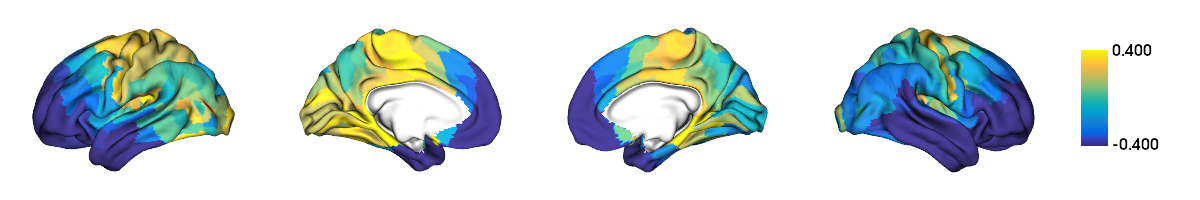

In [25]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LSUB.svg',
                 )

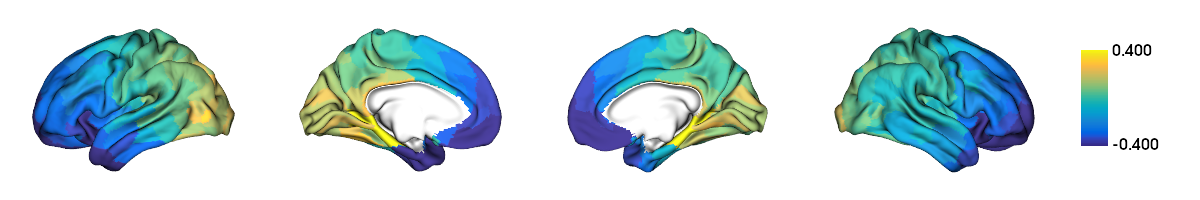

In [26]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LCA.svg',
                 )


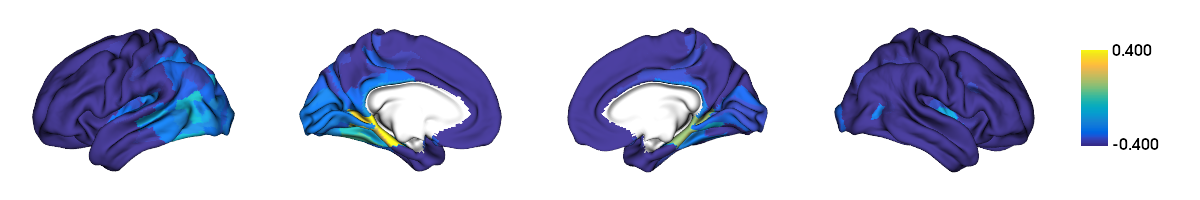

In [27]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = plot_funcs.parula_cmap(), 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/scov_r1_G1_cortex_LDG.svg'                 
                 )
                

### read-in the gradients data of the genetic correlation (gen)

In [28]:
g = h5py.File(os.path.join(outdir, 'Hmean709genGradients_left.h5'), 'r')
data = np.array(g['data']).T

G1_gen_LSUB = data[0:1024,0]
G1_gen_LCA  = data[1024:1024+2048,0]
G1_gen_LDG  = data[1024+2048:1024+2048+1024,0] 

G2_gen_LSUB = data[0:1024,1]
G2_gen_LCA  = data[1024:1024+2048,1]
G2_gen_LDG  = data[1024+2048:1024+2048+1024,1] 



### G1 (gen)

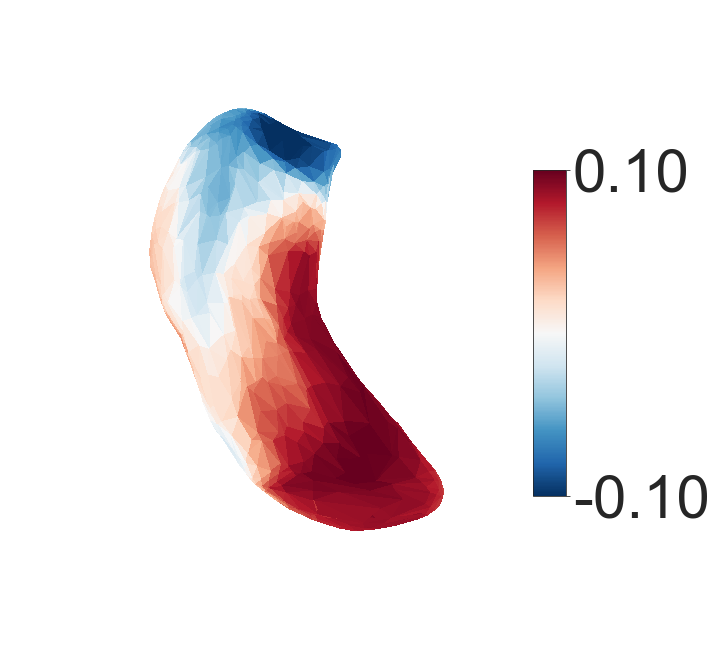

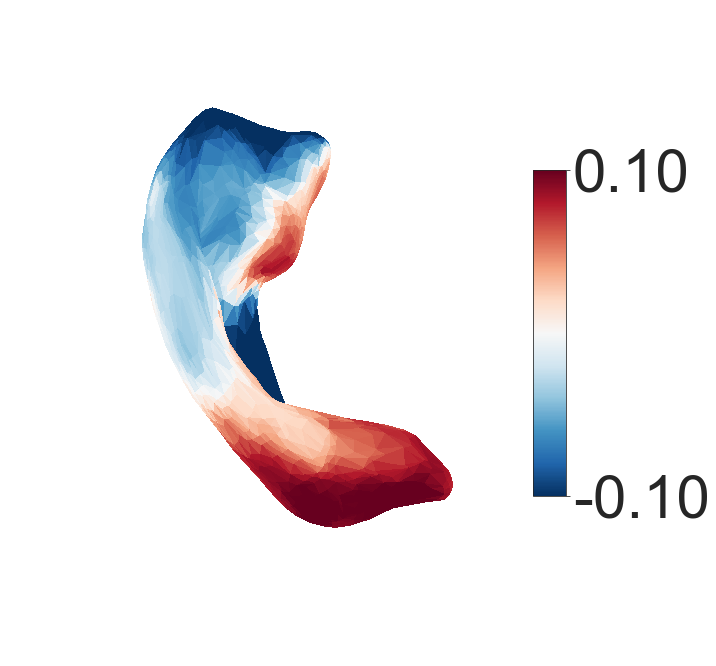

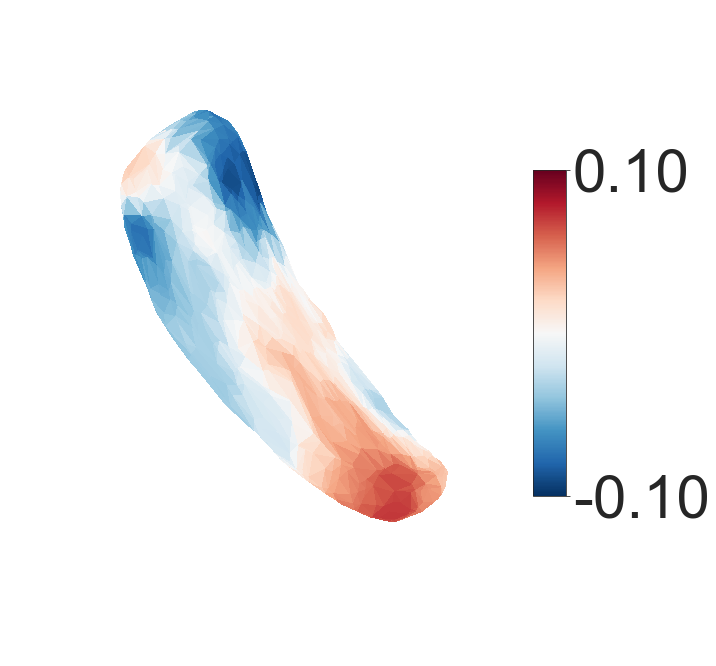

In [29]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G1_gen_LSUB, 
                                  'RdBu_r', -0.1, 0.1)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G1_gen_LCA,
                                   'RdBu_r', -0.1, 0.1)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G1_gen_LDG,
                                   'RdBu_r', -0.1, 0.1)


#fig1.savefig('../figures/gen_G1_lsub.svg', dpi=300)
#fig2.savefig('../figures/gen_G1_lca.svg', dpi=300)
#fig3.savefig('../figures/gen_G1_ldg.svg', dpi=300)

### G2 (gen)

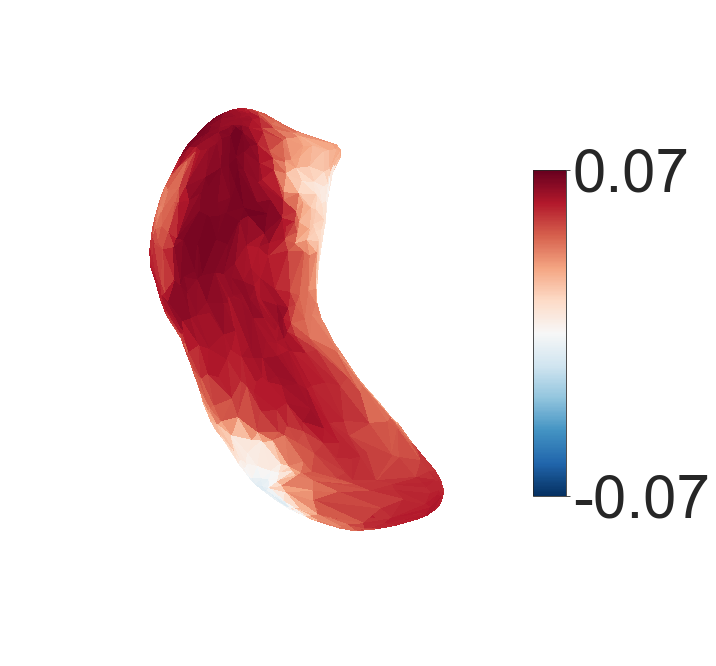

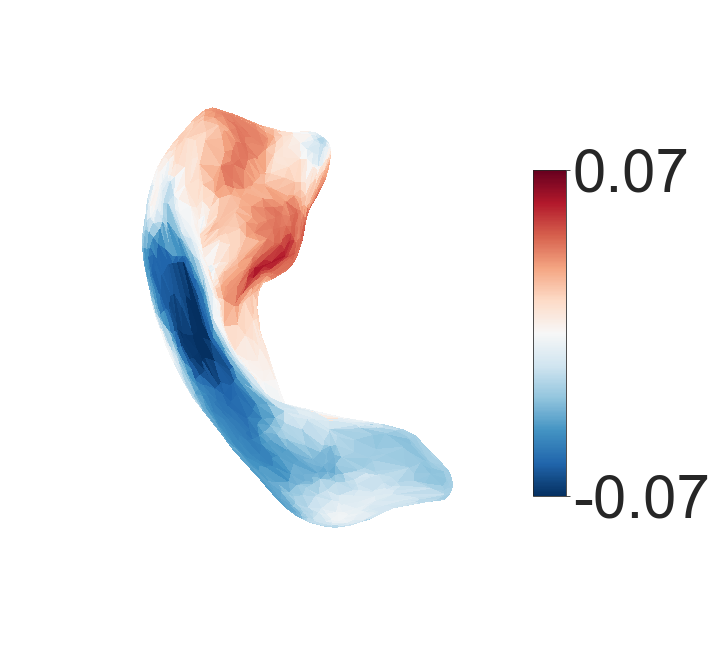

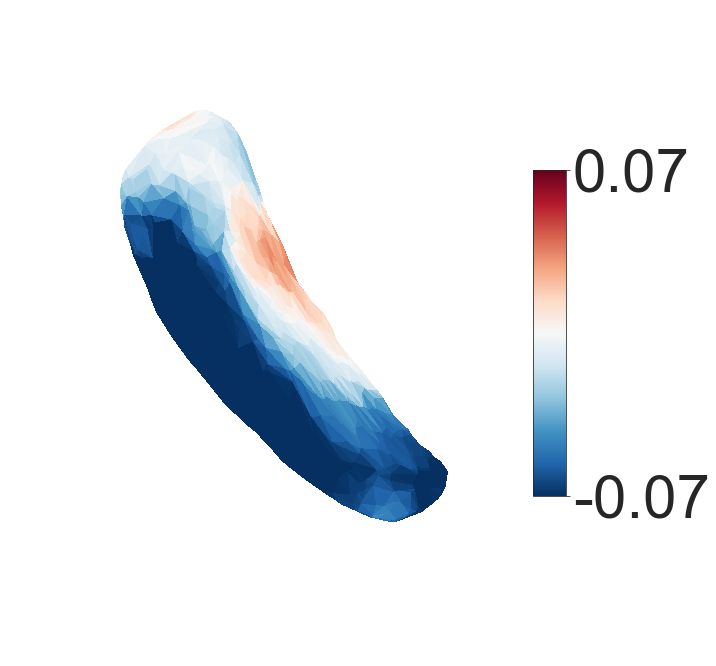

In [30]:
fig1 = plot_funcs.plot_surf_upper2(plot_funcs.xLSUB,
                                  plot_funcs.yLSUB, 
                                  plot_funcs.zLSUB, 
                                  plot_funcs.triLSUB, 
                                  G2_gen_LSUB, 
                                  'RdBu_r', -0.07, 0.07)

fig2 = plot_funcs.plot_surf_upper2(plot_funcs.xLCA, 
                                   plot_funcs.yLCA, 
                                   plot_funcs.zLCA, 
                                   plot_funcs.triLCA, 
                                   G2_gen_LCA,
                                   'RdBu_r',-0.07, 0.07)

fig3 = plot_funcs.plot_surf_upper2(plot_funcs.xLDG, 
                                   plot_funcs.yLDG, 
                                   plot_funcs.zLDG, 
                                   plot_funcs.triLDG, 
                                   G2_gen_LDG,
                                   'RdBu_r', -0.07, 0.07)


#fig1.savefig('../figures/gen_G2_lsub.svg', dpi=300)
#fig2.savefig('../figures/gen_G2_lca.svg', dpi=300)
#fig3.savefig('../figures/gen_G2_ldg.svg', dpi=300)

## projections of hippocampal G1 (gen) onto the hippocampal-cortical gen


In [31]:
h = h5py.File(os.path.join(ddir, 'Hmean709gen_subfields.h5'), 'r')
gen_corr = np.array(h['data'])

print(gen_corr.shape, np.nanmin(gen_corr), np.nanmax(gen_corr))

genncorr_LSUB = gen_corr[:,0:1024]
genncorr_LCA  = gen_corr[:,1024:1024+2048]
genncorr_LDG  = gen_corr[:,1024+2048:1024+2048+1024]



(360, 4096) -0.5069329 1.0


In [32]:
h = h5py.File(os.path.join(ddir, 'Hmean709gen_subfields.h5'), 'r')
gen_corr = np.array(h['data'])

print(gen_corr.shape, np.nanmin(gen_corr), np.nanmax(gen_corr))

genncorr_LSUB = gen_corr[:,0:1024]
genncorr_LCA  = gen_corr[:,1024:1024+2048]
genncorr_LDG  = gen_corr[:,1024+2048:1024+2048+1024]



(360, 4096) -0.5069329 1.0


In [33]:
c1_LSUB = np.zeros((360,))
c1_LCA  = np.zeros((360,))
c1_LDG = np.zeros((360,))

for k in range(0, 360):
    c1_LSUB[k] = np.corrcoef(genncorr_LSUB[k,:], G1_gen_LSUB)[-1:,:-1][0,0]
    c1_LCA[k]  = np.corrcoef(genncorr_LCA[k,:], G1_gen_LCA)[-1:,:-1][0,0]
    c1_LDG[k]  = np.corrcoef(genncorr_LDG[k,:], G1_gen_LDG)[-1:,:-1][0,0]


In [34]:
c1_LSUB_labeled = map_to_labels(c1_LSUB, labeling, mask=mymask) 
c1_LSUB_labeled[np.where(mymask == False)] = np.nan

c1_LCA_labeled = map_to_labels(c1_LCA, labeling, mask=mymask) 
c1_LCA_labeled[np.where(mymask == False)] = np.nan

c1_LDG_labeled = map_to_labels(c1_LDG, labeling, mask=mymask) 
c1_LDG_labeled[np.where(mymask == False)] = np.nan

print(c1_LSUB_labeled.shape, np.nanmin(c1_LSUB_labeled), np.nanmax(c1_LSUB_labeled))
print(c1_LCA_labeled.shape, np.nanmin(c1_LCA_labeled), np.nanmax(c1_LCA_labeled))
print(c1_LDG_labeled.shape, np.nanmin(c1_LDG_labeled), np.nanmax(c1_LDG_labeled))



(64984,) -0.8754650499895955 0.7257769053247067
(64984,) -0.879781626001904 0.5933801949013315
(64984,) -0.8086264569481537 0.6559790547261516


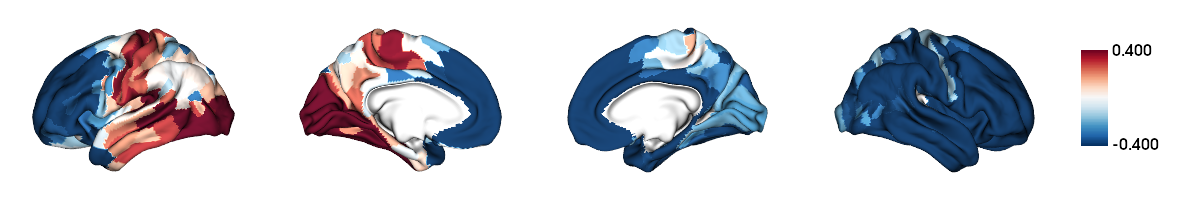

In [35]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LSUB.svg'                
                )


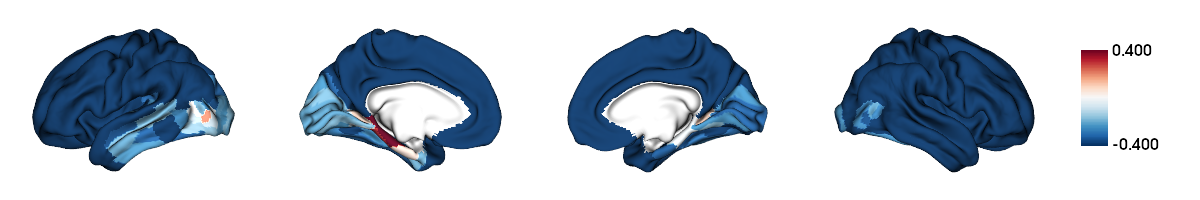

In [36]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LCA.svg'
                )


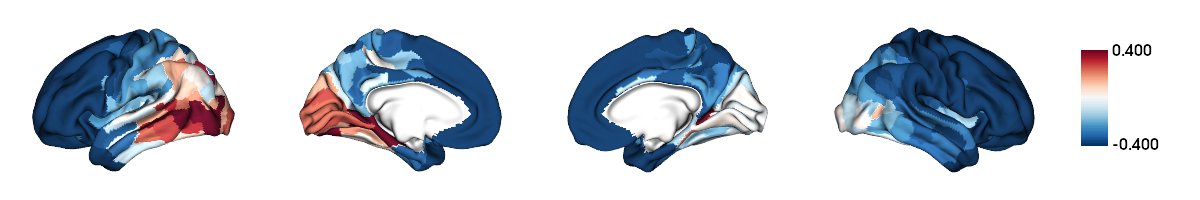

In [37]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = c1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1),
                 size = (1200, 200),
                 cmap = 'RdBu_r', 
                 color_bar = True,
                 color_range = (-0.4, 0.4),
                 interactive = False,
                 zoom = 1.3,
                 embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_r1_G1_cortex_LDG.svg'               
                )


## variogram matching to correct p-values for spatial-autocorrelations

In [38]:
from scipy.io import loadmat

ddir = '../data/tout_group/'

# get surface coordinates & triangles
LSUBfile = os.path.join(ddir, 'surf_lsub.mat')
LSUBsurf = loadmat(LSUBfile)['ave_lsub'][0,0]
xLSUB = LSUBsurf['coord'][0,:]           # (1024,)
yLSUB = LSUBsurf['coord'][1,:]           # (1024,)
zLSUB = -LSUBsurf['coord'][2,:]          # (1024,)

LCAfile = os.path.join(ddir, 'surf_lca.mat')
LCAsurf = loadmat(LCAfile)['ave_lca'][0,0];
xLCA = LCAsurf['coord'][0,:]           # (2048,)
yLCA = LCAsurf['coord'][1,:]           # (2048,)
zLCA = -LCAsurf['coord'][2,:]          # (2048,)

LDGfile = os.path.join(ddir, 'surf_ldg.mat')
LDGsurf = loadmat(LDGfile)['ave_ldg'][0,0];
xLDG = LDGsurf['coord'][0,:]           # (1024,)
yLDG = LDGsurf['coord'][1,:]           # (1024,)
zLDG = -LDGsurf['coord'][2,:]          # (1024,)

coord_LSUB = np.concatenate((xLSUB.reshape(1024,1), 
                             yLSUB.reshape(1024,1), 
                             zLSUB.reshape(1024,1)), axis=1)

coord_LCA  = np.concatenate((xLCA.reshape(2048,1), 
                             yLCA.reshape(2048,1), 
                             zLCA.reshape(2048,1)), axis=1)

coord_LDG  = np.concatenate((xLDG.reshape(1024,1), 
                             yLDG.reshape(1024,1), 
                             zLDG.reshape(1024,1)), axis=1)


In [39]:
points_LSUB = np.array(coord_LSUB, dtype='float64')
faces_LSUB  = np.array(LSUBsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LSUB = geodesic.PyGeodesicAlgorithmExact(points_LSUB, faces_LSUB)
distance_LSUB = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LSUB.geodesicDistances(sourceIndex, targetIndex)
    distance_LSUB[i, :] = distIndex

In [40]:
points_LCA = np.array(coord_LCA, dtype='float64')
faces_LCA  = np.array(LCAsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LCA = geodesic.PyGeodesicAlgorithmExact(points_LCA, faces_LCA)
distance_LCA = np.zeros((2048,2048))

for i in range(0, 2048):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LCA.geodesicDistances(sourceIndex, targetIndex)
    distance_LCA[i, :] = distIndex

In [41]:
points_LCA = np.array(coord_LCA, dtype='float64')
faces_LCA  = np.array(LCAsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LCA = geodesic.PyGeodesicAlgorithmExact(points_LCA, faces_LCA)
distance_LCA = np.zeros((2048,2048))

for i in range(0, 2048):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance 
    distIndex, best_source = geoalg_LCA.geodesicDistances(sourceIndex, targetIndex)
    distance_LCA[i, :] = distIndex

In [42]:
points_LDG = np.array(coord_LDG, dtype='float64')
faces_LDG  = np.array(LDGsurf['tri'], dtype='int32') -1

# Initialise the PyGeodesicAlgorithmExact class instance
geoalg_LDG = geodesic.PyGeodesicAlgorithmExact(points_LDG, faces_LDG)
distance_LDG = np.zeros((1024,1024))

for i in range(0, 1024):
    sourceIndex = np.array([i])  
    targetIndex = None
    # Compute the geodesic distance and the path
    distIndex, best_source = geoalg_LDG.geodesicDistances(sourceIndex, targetIndex)
    distance_LDG[i, :] = distIndex

In [43]:
from scipy.sparse.csgraph import dijkstra

distance_LSUB = dijkstra(distance_LSUB, directed=False)
distance_LSUB_idx_sorted = np.argsort(distance_LSUB, axis=1)

distance_LCA = dijkstra(distance_LCA, directed=False)
distance_LCA_idx_sorted = np.argsort(distance_LCA, axis=1)

distance_LDG = dijkstra(distance_LDG, directed=False)
distance_LDG_idx_sorted = np.argsort(distance_LDG, axis=1)


## similarities between G1(sic) and G1 (fc)

In [44]:


ddir = '../data/tout_group/'

# read-in primary and secongardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G1_fc_LSUB = np.array(h1['gradients_'][0:1024,0])
G1_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,0])
G1_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,0])

G2_fc_LSUB = np.array(h1['gradients_'][0:1024,1])
G2_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,1])
G2_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,1])



In [45]:


print(pearsonr(G1_fc_LSUB, G1_sic_LSUB ))
print(pearsonr(G1_fc_LCA, G1_sic_LCA ))
print(pearsonr(G1_fc_LDG, G1_sic_LDG ))



(0.8815639860321456, 0.0)
(0.8630543819132159, 0.0)
(0.876595717217076, 0.0)


In [46]:
from brainspace.null_models import SampledSurrogateMaps

n_surrogate_datasets = 1000

# Note: number samples must be greater than number neighbors
num_samples = 100
num_neighbors = 50

ssm_LSUB = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LSUB.fit(distance_LSUB, distance_LSUB_idx_sorted)

ssm_LCA = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LCA.fit(distance_LCA, distance_LCA_idx_sorted)

ssm_LDG = SampledSurrogateMaps(ns=num_samples, knn=num_neighbors, random_state=0)
ssm_LDG.fit(distance_LDG, distance_LDG_idx_sorted)


G1_sic_LSUB_surrogates = ssm_LSUB.randomize(G1_sic_LSUB, n_rep=n_surrogate_datasets)
G1_sic_LCA_surrogates = ssm_LCA.randomize(G1_sic_LCA, n_rep=n_surrogate_datasets)
G1_sic_LDG_surrogates = ssm_LDG.randomize(G1_sic_LDG, n_rep=n_surrogate_datasets)


G1_lsub:
 ABC 0.88156 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.86305 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00

G1_ldg:
 ABC 0.87660 
 Obs      : 0.00000e+00
 Variogram: 0.00000e+00



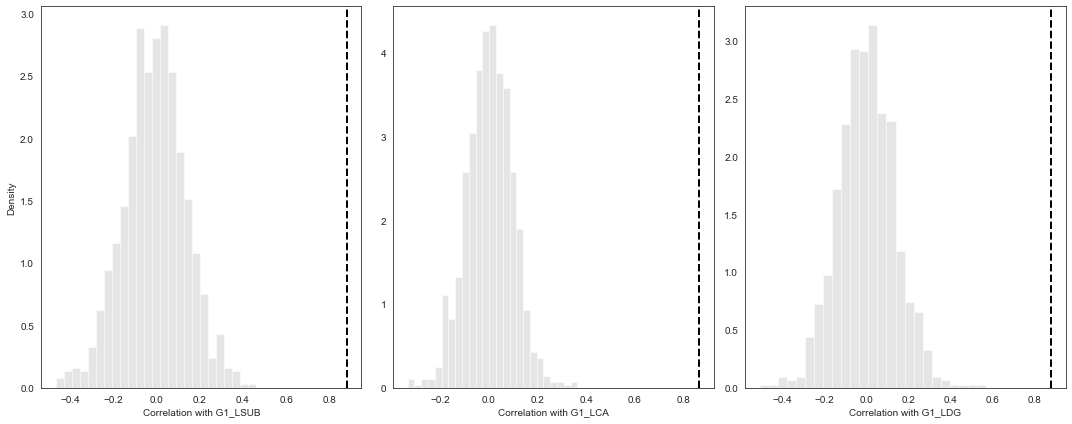

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_sic_LSUB,
         'G1_LCA' : G1_sic_LCA,
         'G1_LDG' : G1_sic_LDG}

rand = {'G1_LSUB': G1_sic_LSUB_surrogates,
           'G1_LCA' : G1_sic_LCA_surrogates,
           'G1_LDG' : G1_sic_LDG_surrogates}


for k, (fn, data) in enumerate(rand.items()):

    if k == 0:
        XG = G1_fc_LSUB
                
    if k == 1:
        XG = G1_fc_LCA
        
    if k == 2:
        XG = G1_fc_LDG
    
    r_obs, pv_obs = pearsonr(feats[fn], XG)

    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

## similarities between G1 (gen) and G1 (FC)

In [48]:
print(pearsonr(G1_fc_LSUB, G1_gen_LSUB ))
print(pearsonr(G1_fc_LCA, G1_gen_LCA ))
print(pearsonr(G1_fc_LDG, G1_gen_LDG ))


(0.6711740250041487, 5.052656510806426e-135)
(0.4106185087478693, 3.9225372925258332e-84)
(0.7511077171418354, 1.643587705241546e-186)


In [49]:
G1_gen_LSUB_surrogates = ssm_LSUB.randomize(G1_gen_LSUB, n_rep=n_surrogate_datasets)
G1_gen_LCA_surrogates = ssm_LCA.randomize(G1_gen_LCA, n_rep=n_surrogate_datasets)
G1_gen_LDG_surrogates = ssm_LDG.randomize(G1_gen_LDG, n_rep=n_surrogate_datasets)


G1_lsub:
 ABC 0.67117 
 Obs      : 5.05266e-135
 Variogram: 0.00000e+00

G1_lca:
 ABC 0.41062 
 Obs      : 3.92254e-84
 Variogram: 1.00000e-03

G1_ldg:
 ABC 0.75111 
 Obs      : 1.64359e-186
 Variogram: 0.00000e+00



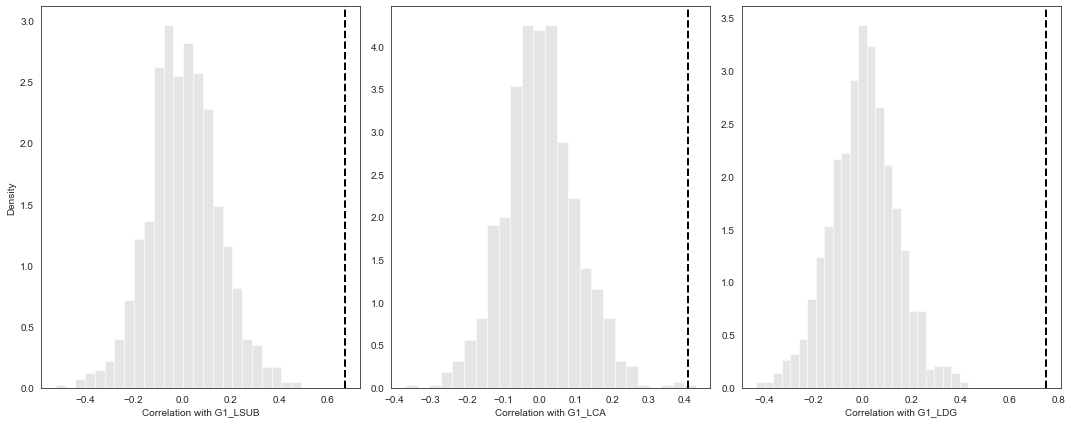

In [50]:


fig, axs = plt.subplots(1, 3, figsize=(15,6))

feats = {'G1_LSUB': G1_gen_LSUB,
         'G1_LCA' : G1_gen_LCA,
         'G1_LDG' : G1_gen_LDG}

rand = {'G1_LSUB': G1_gen_LSUB_surrogates,
           'G1_LCA' : G1_gen_LCA_surrogates,
           'G1_LDG' : G1_gen_LDG_surrogates}

for k, (fn, data) in enumerate(rand.items()):
    if k == 0:
        XG = G1_fc_LSUB   
    if k == 1:
        XG = G1_fc_LCA
    if k == 2:
        XG = G1_fc_LDG
    r_obs, pv_obs = pearsonr(feats[fn], XG)
    # Compute perm pval
    r_rand = np.asarray([pearsonr(XG, d)[0] for d in data])
    pv_rand = np.mean(np.abs(r_rand) >= np.abs(r_obs))

    # Plot null dist
    axs[k].hist(r_rand, bins=25, density=True, alpha=0.5, color=(.8, .8, .8))
    axs[k].axvline(r_obs, lw=2, ls='--', color='k')
    axs[k].set_xlabel(f'Correlation with {fn}')
    if k == 0:
        axs[k].set_ylabel('Density')

    print(f'{fn.capitalize()}:\n ABC {r_obs:.5f} \n Obs      : {pv_obs:.5e}\n '
          f'Variogram: {pv_rand:.5e}\n')

fig.tight_layout()
plt.show()

